In [4]:
import sys
from source_data import Requests,JourneyTimes,ShortestPathFinder
import pandas as pd
import numpy as np
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point,LineString
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
OUT_FOLDER = r'output_logs'

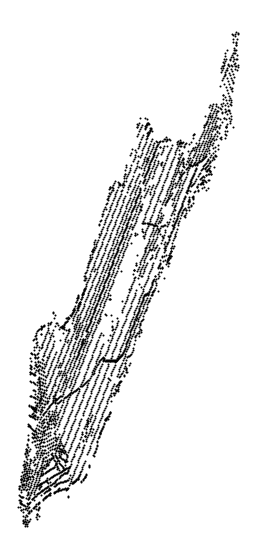

In [5]:
# get the nyc intersection positions
intersections = pd.read_csv(r'datasets/ny_intersections.csv')
intersections.head()

# create a bunch of points
inter_points = [dict(node=i,geometry=Point(x,y))
                for i,x,y in intersections.to_records()]
intersections = gpd.GeoDataFrame(inter_points,crs='EPSG:4326')# .to_crs(epsg=3857)
# intersections.head()

# plot the intersections
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax = intersections.plot(color='black',markersize=1,ax=ax)
plt.axis('off')
plt.savefig("intersection_map.jpg")

In [6]:
# get the model output logs
out_logs = []
for fnm in os.listdir(OUT_FOLDER):
    print(fnm)
    out_logs.append(pd.read_csv(os.path.join(OUT_FOLDER,fnm),dtype=dict(passenger_id=int)))

# concatenate them together
out_df = pd.concat(out_logs)
out_df.head()

0_0.csv


,time_stamp,passenger_id,cab_id,event,location
0,39,74,v15,pickup,185
1,47,63,v25,pickup,441
2,35,10,v29,pickup,420
3,46,182,v30,pickup,1231
4,30,20,v45,pickup,662


Check the passengers are only picked up and dropped off once:
- so passengers are being picked up and dropped off more than once.
- suspect there is something wrong with the booking system - when existing passengers are re-routed

In [7]:
np.unique((out_df['passenger_id'].astype(str)+" "+out_df['event']).value_counts().values)

array([1, 2, 3])

In [8]:
# print out the time range
out_df.describe()

,time_stamp,passenger_id,location
count,35346.000000,35346.000000,35346.000000
mean,1823.569852,10223.695864,1516.352770
std,1006.066820,6177.728587,814.813616
min,30.000000,0.000000,3.000000
25%,966.000000,4889.250000,945.000000
50%,1795.000000,9949.500000,1401.000000
75%,2688.000000,15407.500000,2048.000000
max,3600.000000,22602.000000,4074.000000


In [ ]:
# get all of the requests to see how many were satisfied



In [9]:
# interesting cab = v740
focus = 'v740'

# follow a cap that doesn't have lots of errors
cab_data = out_df.groupby(['cab_id'])
# for cab,data in cab_data:
    
#     # count pickups and drop offs
#     picks_drops = (data['passenger_id'].astype(str)+
#                    " "+data['event']).value_counts()
#     if picks_drops.values[0] == 1:
        
#         print(data)
to_focus = cab_data.get_group('v740')
to_focus

,time_stamp,passenger_id,cab_id,event,location
466,99,662,v740,pickup,1599
873,167,662,v740,dropoff,1791
1134,180,1103,v740,pickup,1791
3124,427,1103,v740,dropoff,1317
3373,450,2864,v740,pickup,1317
6546,758,2864,v740,dropoff,579
6909,798,4863,v740,pickup,604
6910,798,5166,v740,pickup,604
10877,1168,4863,v740,dropoff,1006
11859,1248,5166,v740,dropoff,847


In [10]:
# check the capacity of the cab
state = to_focus.copy()
state['change'] = to_focus['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
state['capacity'] = np.cumsum(state['change'])
state

,time_stamp,passenger_id,cab_id,event,location,change,capacity
466,99,662,v740,pickup,1599,1,1
873,167,662,v740,dropoff,1791,-1,0
1134,180,1103,v740,pickup,1791,1,1
3124,427,1103,v740,dropoff,1317,-1,0
3373,450,2864,v740,pickup,1317,1,1
6546,758,2864,v740,dropoff,579,-1,0
6909,798,4863,v740,pickup,604,1,1
6910,798,5166,v740,pickup,604,1,2
10877,1168,4863,v740,dropoff,1006,-1,1
11859,1248,5166,v740,dropoff,847,-1,0
